# Entropic estimation of optimal transport maps

We experiment with the

The idea ...

Setting : 2-samples estimates

*copié de la page 9*

The article proposes the following estimator of the map :
$$T_{\varepsilon,(n, n)}(x)=\frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}$$
where $g_{\varepsilon,(n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$, obtained by the ouput of Sinkhorn algo..

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.costs import SqPNorm, SqEuclidean
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

In [3]:
def create_points(rng, n, d, T): # T must be a monotone scalar function !
    rngs = jax.random.split(rng, 2)

    x = jax.random.uniform(rngs[0], (n,d), minval = -1, maxval = 1)
    z = jax.random.uniform(rngs[1], (n,d), minval = -1, maxval = 1)

    y = T(z)

    return x, y

Create a {class}`~ott.problems.linear.linear_problem.LinearProblem` comparing two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [4]:
def entropic_map_estimator_TWO_sample(ot_sink):
    DualPotentials = ot_sink.to_dual_potentials()
    return DualPotentials.transport

In [5]:
def OT_sinkhorn_solved(x,y , alpha, epsilon = None):

    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)
    if epsilon == None : # epsilon optimaly chosen  according to `Pooladian and Niles-Weed, 2021`
        epsilon = n ** (- 1/(d_ + alpha_bar + 1))
        print("Chosen epsilon :", epsilon)

    geom = pointcloud.PointCloud(x, y, cost_fn = SqEuclidean() , epsilon = epsilon)
    ot_prob = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_sink = solver(ot_prob)


    return ot_sink

In [6]:
rng = jax.random.PRNGKey(0)
T = lambda x : 3 * x**2 * jnp.sign(x) # jnp.log(1.2 + x) #
n = 1000
d = 2
alpha = 1

x,y = create_points(rng, n, d, T)
ot_sink = OT_sinkhorn_solved(x,y , alpha, epsilon = 0.01)


[]

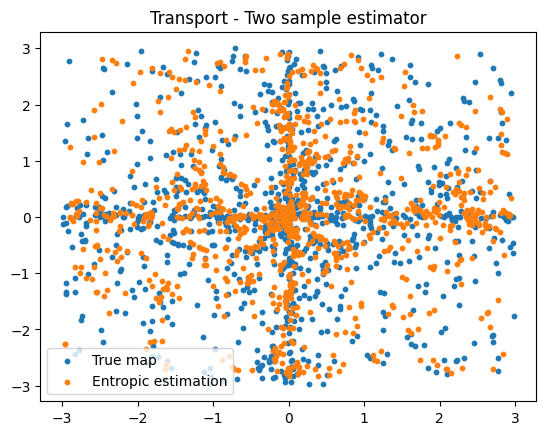

In [7]:
T_hat_2 = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)

rng = jax.random.PRNGKey(1)
x_tilde, _ = create_points(rng, n, d, T)

y_tilde = T(x_tilde)
y_tilde_estimated_2 = T_hat_2(x_tilde)


plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10, label = "True map")
plt.scatter(y_tilde_estimated_2[:,0], y_tilde_estimated_2[:,1], s = 10, label = "Entropic estimation")
plt.title("Transport - Two sample estimator")
plt.legend()
plt.plot()


## Convergence bound


In [8]:
def entropic_map_mse(rng, n_, T_hat, T):
    X_ = jax.random.uniform(rng, (n_,d), minval = -1, maxval = 1)
    return n_**(-1) * jnp.sum((T_hat(X_) - T(X_))**2)

In [9]:
def bound(alpha, d):
    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)

    bound_fn = lambda n: n**(- (alpha_bar+1)/(2*(d_+alpha_bar+1))) * jnp.log(n)

    return bound_fn

def minimax_bound(alpha,d):
    bound_fn = lambda n: n**(-2*alpha/(2*alpha -2 +d))
    return bound_fn

In [10]:
rng = jax.random.PRNGKey(2)
rngs = jax.random.split(rng, 2)
N = 10000

n_stacked = [100, 500, 1000, 2000, 5000, 10000]

mse_stacked = []
for k in n_stacked :
    x,y = create_points(rngs[0], n, d, T)
    ot_sink = OT_sinkhorn_solved(x, y, alpha, epsilon = None)
    T_hat = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)
    mse = entropic_map_mse(rngs[1], N, T_hat, T)

    mse_stacked.append(mse)

bound_fn = bound(alpha, d)
bound_minimax_fn = minimax_bound(alpha, d)


minimax_bound_evaluations = [bound_minimax_fn(j) for j in n_stacked]
bound_evaluations = [bound_fn(j).item() for j in n_stacked]

Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794


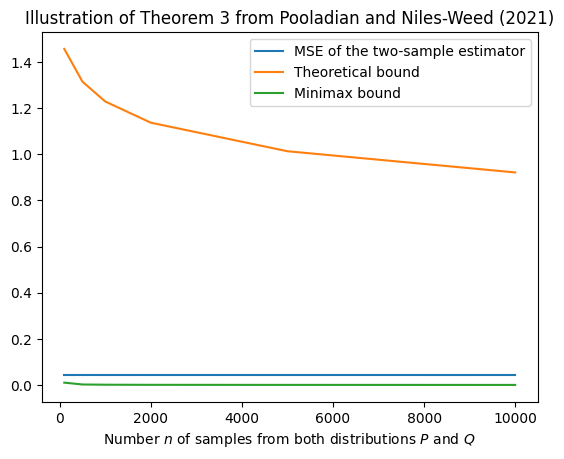

In [11]:
plt.figure()
plt.plot(n_stacked, mse_stacked, label = "MSE of the two-sample estimator")
plt.plot(n_stacked, bound_evaluations , label = "Theoretical bound")
plt.plot(n_stacked, minimax_bound_evaluations , label = "Minimax bound")
plt.legend()
plt.title("Illustration of Theorem 3 from Pooladian and Niles-Weed (2021)")
plt.xlabel("Number $n$ of samples from both distributions $P$ and $Q$")
plt.show()

## Données réelles
MNIST..

In [27]:
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_datasets as tfds

def load_mnist():
    mnist_data, info = tfds.load("mnist", split="train", as_supervised=True, with_info=True)

    def preprocess_image(image, label):
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, (28, 28))
        return image, label

    mnist_data = mnist_data.map(preprocess_image)

    mnist_images, mnist_labels = [], []
    for image, label in tfds.as_numpy(mnist_data):
        mnist_images.append(image)
        mnist_labels.append(label)

    mnist_images = jnp.array(mnist_images)
    mnist_labels = jnp.array(mnist_labels)

    return mnist_images, mnist_labels


mnist_images, mnist_labels = load_mnist()


In [118]:
n = 2000
d = 28**2

A = jnp.array([0, 1, 2, 3, 4])
B = jnp.array([5, 6, 7, 8 ,9])

indices_A = jnp.where(jnp.isin(mnist_labels, A))[0]
indices_B = jnp.where(jnp.isin(mnist_labels, B))[0]

train_ind_A = indices_A[:n]
test_ind_A = indices_A[n:]

train_ind_B = indices_B[:n]
test_ind_B = indices_B[n:]

x = mnist_images[train_ind_A, :, :, 0].reshape((n, -1))
y = mnist_images[train_ind_B, :, :, 0].reshape((n, -1))

x_test = mnist_images[test_ind_A, :, :, 0].reshape((test_ind_A.shape[0], -1))

Transport des 4 vers les 8. Puis calcul de la entropic map estimation.

In [119]:
ot_mnist = OT_sinkhorn_solved(x, y , 0, epsilon = 0.000001)
T_hat = entropic_map_estimator_TWO_sample(ot_sink = ot_mnist)

## Expériences
### Cohérence des labels

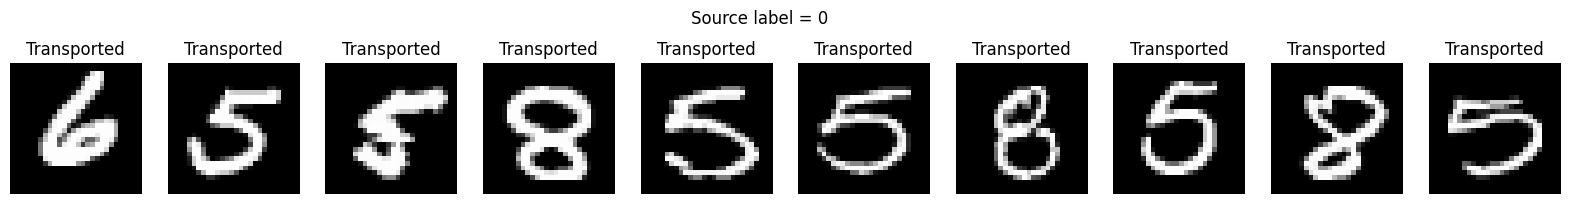

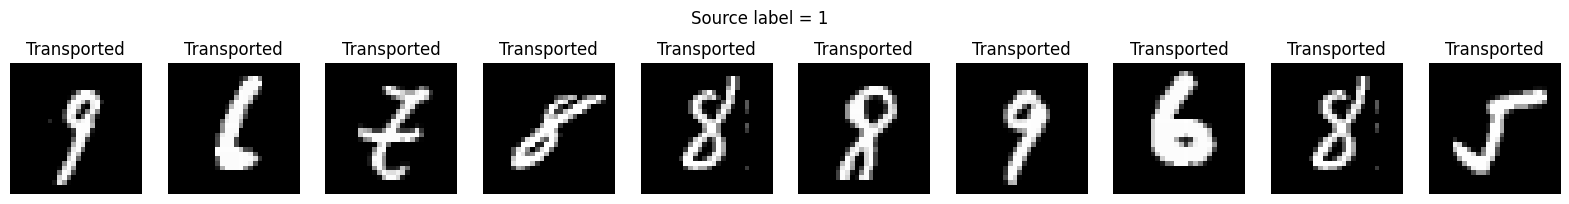

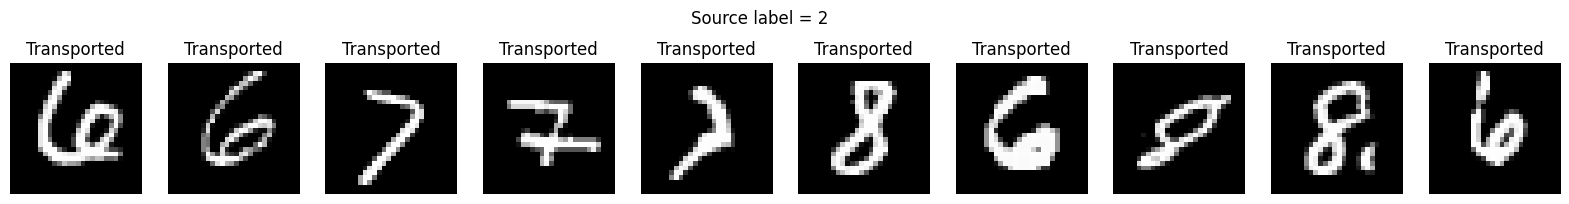

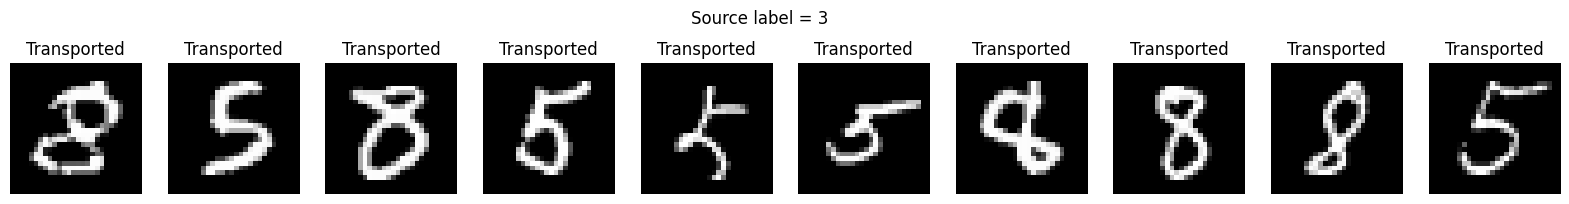

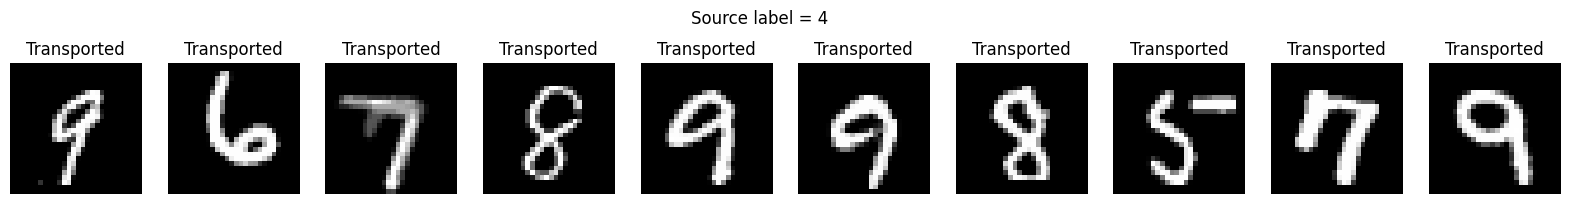

In [120]:
n_samples = 10
for label in A :
  count = 0
  i=0

  while count < n_samples :
    if mnist_labels[train_ind_A[i]] == label:

      if count == 0:
          fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 2, 2))
          fig.suptitle(f"Source label = {label}", y=1.05)
          plt.subplots_adjust(top=0.8)

      axes[count].imshow(T_hat(mnist_images[indices_A[i], :, :, 0].reshape((1, -1))).reshape(28, 28), cmap='gray')
      axes[count].set_title(f"Transported")
      axes[count].axis('off')
      count += 1

      i += 1

    else :
      i += 1


### Joujou avec mask

In [63]:
size = 784

mask_top = jnp.concatenate([jnp.ones(size//2), jnp.zeros(size//2)])
mask_bot = jnp.concatenate([jnp.zeros(size//2), jnp.ones(size//2)])

In [81]:
rng = jax.random.PRNGKey(2)
rngs = jax.random.split(rng, 2)
x_tilde = mnist_images[test_ind_A[0].item(), :, :, 0].reshape(1,-1)
y_tilde = T_hat(x_tilde)

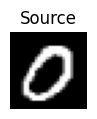

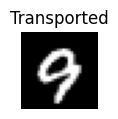

In [82]:
plt.figure(figsize=(1, 1))
plt.imshow(x_tilde.reshape(28,28), cmap='gray')
plt.title(f"Source")
plt.axis('off')
plt.show()

plt.figure(figsize=(1, 1))
plt.imshow(y_tilde.reshape(28,28), cmap='gray')
plt.title(f"Transported")
plt.axis('off')
plt.show()

In [83]:
y_tilde_top = T_hat(x_tilde * mask_top)
y_tilde_bot = T_hat(x_tilde * mask_bot)

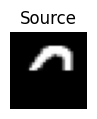

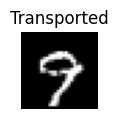

In [88]:
plt.figure(figsize=(1, 1))
plt.imshow((x_tilde * mask_top).reshape(28,28), cmap='gray')
plt.title(f"Source")
plt.axis('off')
plt.show()

plt.figure(figsize=(1, 1))
plt.imshow(y_tilde_top.reshape(28,28), cmap='gray')
plt.title(f"Transported")
plt.axis('off')
plt.show()

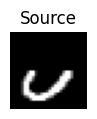

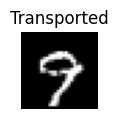

In [87]:
plt.figure(figsize=(1, 1))
plt.imshow((x_tilde * mask_bot).reshape(28,28), cmap='gray')
plt.title(f"Source")
plt.axis('off')
plt.show()

plt.figure(figsize=(1, 1))
plt.imshow(y_tilde_bot.reshape(28,28), cmap='gray')
plt.title(f"Transported")
plt.axis('off')
plt.show()